<h1>Data set available <a href="https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data">here</a></h1>

Previously, we have seen the methods used to clean our data, and missing value imputation methods
This notebook Primarily focuses on EDA
### Questions to answer with this dataset
1. What is the distribution of the dataset? Is it skewed? Are there outliers?
2. How we do deal with skew?
3. Fun facts about the dataset:
   - Average PM2.5 in each month/week
   - 
4. Are we able to determine which factors will affect PM2.5?
In the next notebook, we will use the gained knowledge to create Regression Model.
<!-- 5. Are we able to estimate the PM2.5 levels with other variables in this dataset with a predictive model?
1. What are some of the use cases of this predictive model? -->


In [1]:
import pandas as pd
import numpy as np
from scripts.datacleaningutils import datacleaning
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

C:\Users\maxwe\AppData\Local\Temp\ipykernel_20864\984889995.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("cleaned.csv")

In [3]:
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,2013.0,3.0,1.0,0.0,6.00,8.25,6.25,14.25,275.0,81.00,-0.550,1024.125,-20.750,0.0,5.375,NNW
1,2013.0,3.0,1.0,1.0,5.50,12.25,6.75,14.00,275.0,81.00,-0.800,1024.625,-21.125,0.0,4.100,NW
2,2013.0,3.0,1.0,2.0,4.75,5.50,7.25,15.50,275.0,71.75,-1.175,1024.850,-23.000,0.0,5.375,NNW
3,2013.0,3.0,1.0,3.0,4.25,5.00,5.25,17.00,325.0,70.50,-1.400,1025.775,-23.975,0.0,4.450,N
4,2013.0,3.0,1.0,4.0,4.00,4.75,6.25,16.00,300.0,75.50,-1.925,1026.625,-23.250,0.0,2.900,NNW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,15.75,39.25,2.75,30.25,425.0,69.50,12.500,1013.500,-16.200,0.0,2.400,NW
35060,2017.0,2.0,28.0,20.0,16.75,37.25,3.25,41.00,475.0,52.50,11.600,1013.600,-15.100,0.0,0.900,WNW
35061,2017.0,2.0,28.0,21.0,18.00,40.50,4.75,49.50,575.0,41.75,10.800,1014.200,-13.300,0.0,1.100,NW
35062,2017.0,2.0,28.0,22.0,15.00,38.50,6.25,55.75,625.0,35.25,10.500,1014.400,-12.900,0.0,1.200,NNW


### Part 1: What is the distribution of the dataset? Is it skewed? Are there outliers?
We wil start by checking the distributions of each column of data. This can be done using a KDE matrix

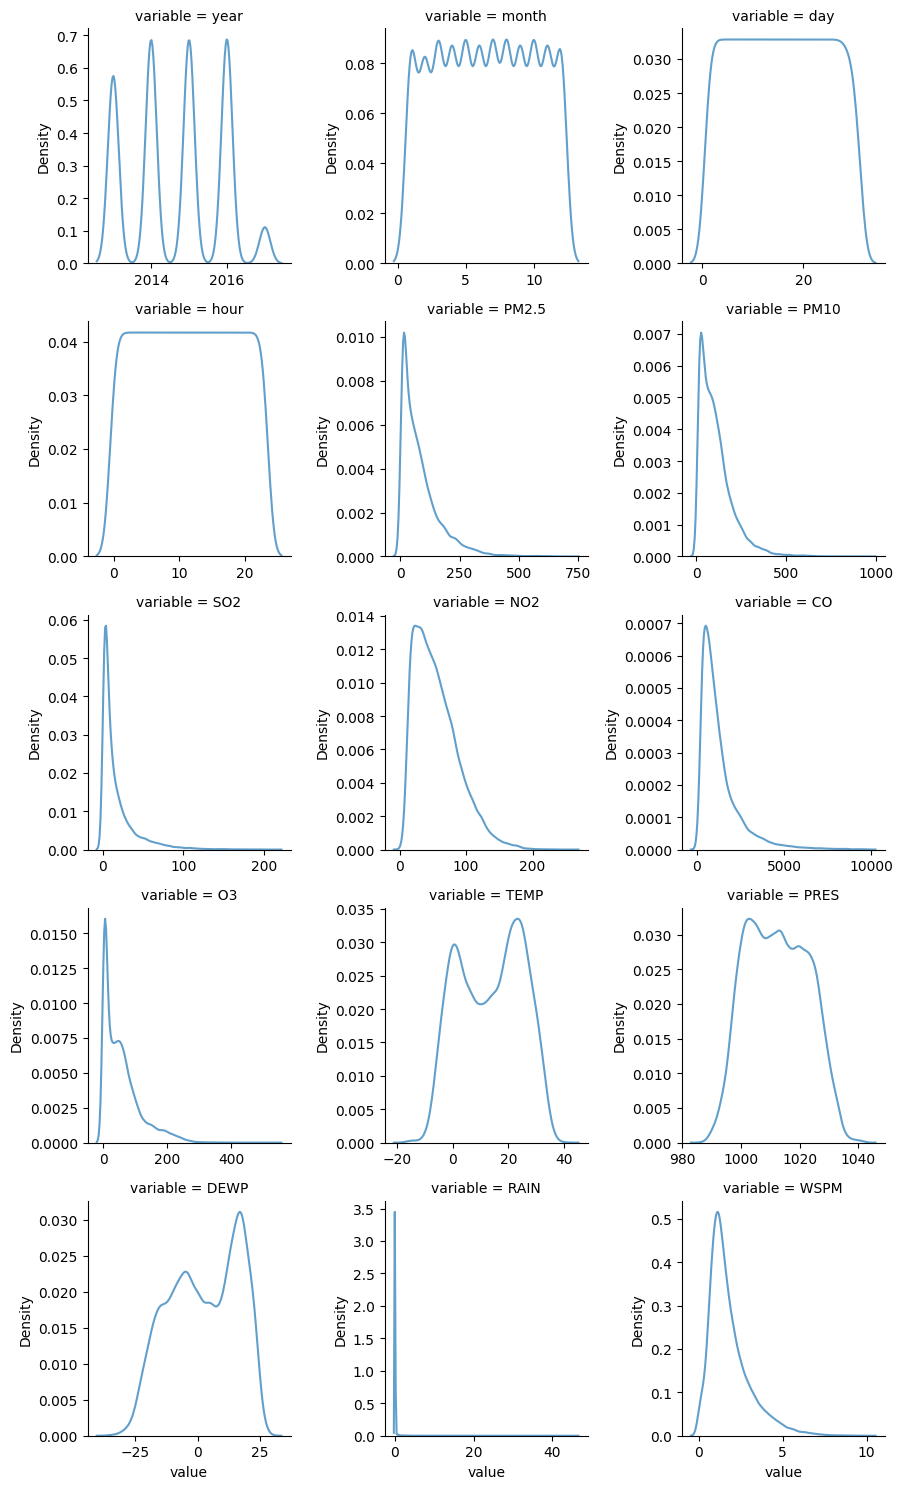

In [4]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# melt df
melted_df = pd.melt(df, value_vars=numerical_columns.columns)

# use sns facet for kde
g = sns.FacetGrid(melted_df, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', alpha=0.7)
g.add_legend()
plt.show()

### From the KDE plot above, we have reason to suspect that PM2.5, PM10, SO2, NO2, CO, O3, and Rain are highly skewed. To confirm this, we can check the skew values of the numeric values. We will ignore the columns regarding time.

In [5]:
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
numeric_df = df[numeric_columns]
skewed_cols = []
# Calculate skewness
skew_values = numeric_df.skew()
print("Skewed values:")
for i in range(len(skew_values)):
    if abs(skew_values.values[i]) > 0.6:
        print(f"{skew_values.index[i]} :  {skew_values.values[i]}")
        skewed_cols.append(skew_values.index[i])

Skewed values:
PM2.5 :  1.9430598625750046
PM10 :  1.8806887563244385
SO2 :  2.6185915611409176
NO2 :  0.9645048524019495
CO :  2.4404598409443117
O3 :  1.4619928300095857
RAIN :  27.606606048748002
WSPM :  1.5160277339355892


### What a shocker... Our dataset is greatly skewed. In particular, RAIN is a column that shows significant skew. This could mean that this particular area (of 4 districts mentioned) rains very rarely. Let's check the value counts to confirm this.

In [6]:
rain_zero_count = (numeric_df['RAIN'] == 0).sum()
total_length = len(numeric_df)
ratio = rain_zero_count / total_length
print(f"Proportion of non-rainy hours {ratio}")

Proportion of non-rainy hours 0.9562514259639516


### Well it might seem that over 95% of the data set represents that it is not raining.
### The naiive approach to deal with such dominance would be to drop the column. However, we need to verify this through more rigorous experimentation

### Part 3: How we do deal with skew?
Before we proceed with further exploration of data, it is crucial that we deal with the skew of data (with exeption to RAIN)

We will use logarithmic transformation to transform skewed data. Why?
1. It is a convenient way to transform skew variables into normalised datasets
2. Reduce the variability of data, including outlying observations
   
<a href="https://www.crn.in/columns/lets-discuss-the-advanced-techniques-for-handling-skewed-datasets-in-machine-learning/#:~:text=Log%20transformation%20is%20a%20popular,those%20that%20have%20outlying%20observations.">read here</a>

In [7]:
# defining a fn to apply log transform
def log_transform_columns(dataframe, columns):
    transformed_df = dataframe.copy()
    
    # Apply log transformation to specified columns
    for column in columns:
        transformed_df[column] = np.log1p(transformed_df[column])  # Use np.log1p to handle zero values
    
    return transformed_df

In [8]:
# recall that our skewed columns are...
skewed_cols

['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'RAIN', 'WSPM']

In [9]:
# apply the transformation to selected columns
columns_to_transform = skewed_cols
transformed_df = log_transform_columns(df, columns_to_transform)

In [10]:
transformed_df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,2013.0,3.0,1.0,0.0,1.945910,2.224624,1.981001,2.724580,5.620401,4.406719,-0.550,1024.125,-20.750,0.0,1.852384,NNW
1,2013.0,3.0,1.0,1.0,1.871802,2.583998,2.047693,2.708050,5.620401,4.406719,-0.800,1024.625,-21.125,0.0,1.629241,NW
2,2013.0,3.0,1.0,2.0,1.749200,1.871802,2.110213,2.803360,5.620401,4.287029,-1.175,1024.850,-23.000,0.0,1.852384,NNW
3,2013.0,3.0,1.0,3.0,1.658228,1.791759,1.832581,2.890372,5.786897,4.269697,-1.400,1025.775,-23.975,0.0,1.695616,N
4,2013.0,3.0,1.0,4.0,1.609438,1.749200,1.981001,2.833213,5.707110,4.337291,-1.925,1026.625,-23.250,0.0,1.360977,NNW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,2.818398,3.695110,1.321756,3.442019,6.054439,4.255613,12.500,1013.500,-16.200,0.0,1.223775,NW
35060,2017.0,2.0,28.0,20.0,2.876386,3.644144,1.446919,3.737670,6.165418,3.979682,11.600,1013.600,-15.100,0.0,0.641854,WNW
35061,2017.0,2.0,28.0,21.0,2.944439,3.725693,1.749200,3.921973,6.356108,3.755369,10.800,1014.200,-13.300,0.0,0.741937,NW
35062,2017.0,2.0,28.0,22.0,2.772589,3.676301,1.981001,4.038656,6.439350,3.590439,10.500,1014.400,-12.900,0.0,0.788457,NNW


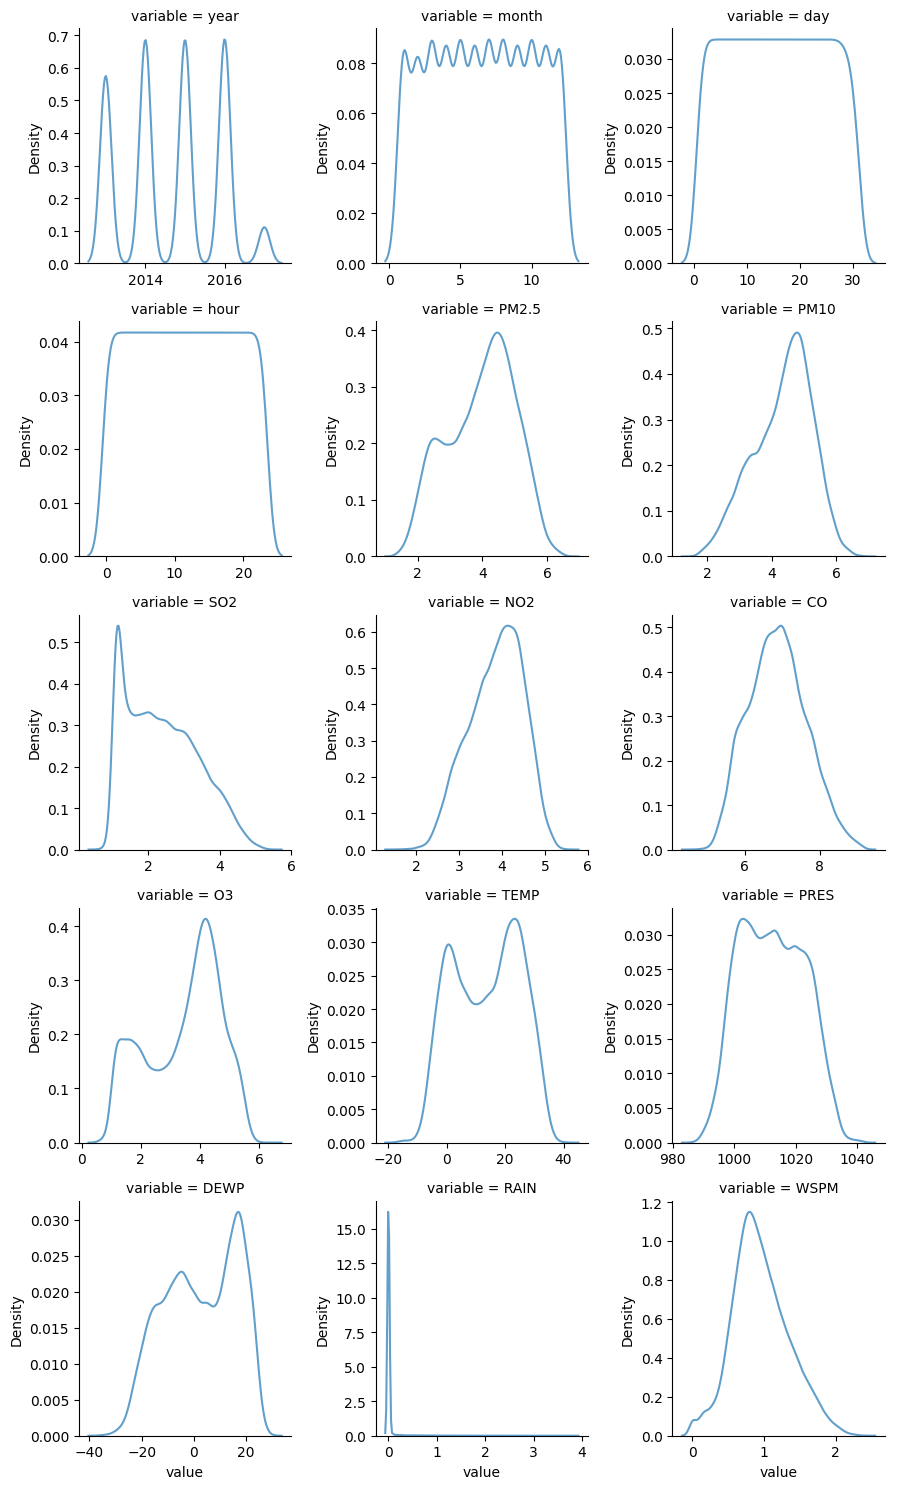

In [11]:
numerical_columns = transformed_df.select_dtypes(include=['float64', 'int64'])

# melt df
melted_df = pd.melt(transformed_df, value_vars=numerical_columns.columns)

# use sns facet for kde
g = sns.FacetGrid(melted_df, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', alpha=0.7)
g.add_legend()
plt.show()

In [12]:
skew_values = transformed_df[numeric_columns].skew()
print("Skewed values:")
for i in range(len(skew_values)):
    print(f"{skew_values.index[i]} :  {skew_values.values[i]}")

Skewed values:
PM2.5 :  -0.2513734844427589
PM10 :  -0.40421431462488283
SO2 :  0.42857276689748836
NO2 :  -0.3148340433326064
CO :  0.1910877120896861
O3 :  -0.4188254107649718
TEMP :  -0.09716580813941722
PRES :  0.09209491332035649
DEWP :  -0.19947297013821333
RAIN :  10.015783952813175
WSPM :  0.3327790693124292


### Wow, it seems like our data is much less skewed after applying the log transformation, with the exception of the dates and the RAIN column (for obvious reasons). Let's begin doing our exploring our data

### Part 3. Fun Facts about the data original data (without log transform)

In [13]:
hourly_mean = df.groupby('hour')['PM2.5'].mean()

# Daily median
daily_mean = df.groupby(['day'])['PM2.5'].mean().reset_index()

# Monthly median
monthly_mean = df.groupby(['month'])['PM2.5'].mean().reset_index()

# Yearly median
yearly_mean = df.groupby('year')['PM2.5'].mean()

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Hourly Mean PM2.5", "Daily Mean PM2.5", "Monthly Mean PM2.5", "Yearly Mean PM2.5"))

# Add traces to subplots
fig.add_trace(go.Scatter(x=hourly_mean.index, y=hourly_mean.values, mode='lines', name='Hourly Mean'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_mean.index, y=daily_mean['PM2.5'], mode='lines', name='Daily Mean'), row=1, col=2)
fig.add_trace(go.Scatter(x=monthly_mean.index, y=monthly_mean['PM2.5'], mode='lines', name='Monthly Mean'), row=2, col=1)
fig.add_trace(go.Scatter(x=yearly_mean.index, y=yearly_mean.values, mode='lines', name='Yearly Mean'), row=2, col=2)

# Update layout
fig.update_layout(height=700, width=1500, title_text="Mean PM2.5 Values", showlegend=False)

# Show plot
fig.show()

### Hourly chart
- The Hourly chart shows a sharp increase after 1900, the persists until 0400 hours. This can be further generalised into saying that the average PM2.5 is higher at dark than it is in day.
- This is further supported from external sources, explaining reasons form a physics stand point:
  
<a href="https://www.nature.com/articles/s41561-023-01157-8#:~:text=With%20emptier%20streets%20and%20quieter,and%2023%3A00%20globally4">Nature.com (click)</a>
```
"With emptier streets and quieter factories, air quality at night is easily perceived as being better than during the day. However, air quality is often at its worst in the early evening hours, with PM2.5 levels peaking between 21:00 and 23:00 globally4. Unfavourable meteorological conditions are an important contributor. As the sun sets, the land surface cools, which in turn cools the overlying air. This leads to the formation of a stable atmosphere layer that suppresses vertical mixing and inhibits pollutant dispersion."
```

<a href="https://airly.org/en/why-is-air-quality-worse-at-night/#:~:text=But%20at%20night%2C%20the%20ground,pollutants%20close%20to%20the%20surface">airly.org (click)</a>
```
"During the day, the sun heats the ground, causing warm air to rise and mix with the atmosphere, which helps to disperse pollutants. But at night, the ground cools down, and this leads to a temperature inversion. This means that the air near the ground becomes colder than the air above it, trapping pollutants close to the surface."
```

### Monthly 
- We can see that the monthly mean bottoms out in month 7 (July). This is because July is monsoon season in Beijing. 
- It also peaks in mont 12 (December). Interestingly enough, our sources state that Beijing doesn't rain in winter (December), and snows a little.
- 
<a href="https://whnt.com/weather/why-was-it-so-windy-after-storms/#:~:text=What%20happens%20is%20that%20the,sinks%20can%20create%20gusty%20winds.">whnt.com (click)</a>
```
What happens is that the air behind the rain and storms is warm, drying and sinking through the atmosphere, creating a low pressure in the “wake” of the departing rain. This descending air has high momentum and as it sinks can create gusty winds.
```

<a href="https://www.chinahighlights.com/beijing/weather.htm#:~:text=The%20rainy%20summer%20season%20is,moderate%20to%20heavy%20thundery%20showers.">chinahighlights.com (click)</a>
```
In the three months of summer (June to August), there are large amounts of rainfall in summer. Heat-driven weather systems often result in rainstorms, hail, and thunderstorms.
However, summer rain typically comes as a heavy/moderate shower during the day, and it will not affect your daily schedule too much. There is practically no rain in winter, but a little snow.
```

### Part 4: Are we able to determine which factors will affect PM2.5?

In [14]:
def scatter_matrix_plot_seaborn(dataframe, target_column):
    # Filter out the target column
    columns_to_plot = [col for col in dataframe.columns if col != target_column]
    num_cols = len(columns_to_plot) // 2
    sns.pairplot(dataframe, y_vars=[target_column], x_vars=columns_to_plot[:num_cols])
    sns.pairplot(dataframe, y_vars=[target_column], x_vars=columns_to_plot[num_cols:])
    
    # Show the plot
    plt.show()

# Assuming df is your DataFrame and 'PM2.5' is the target column

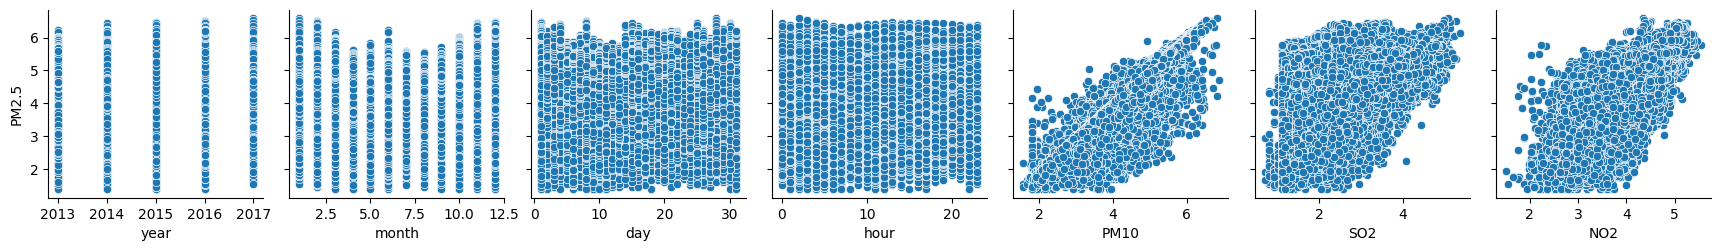

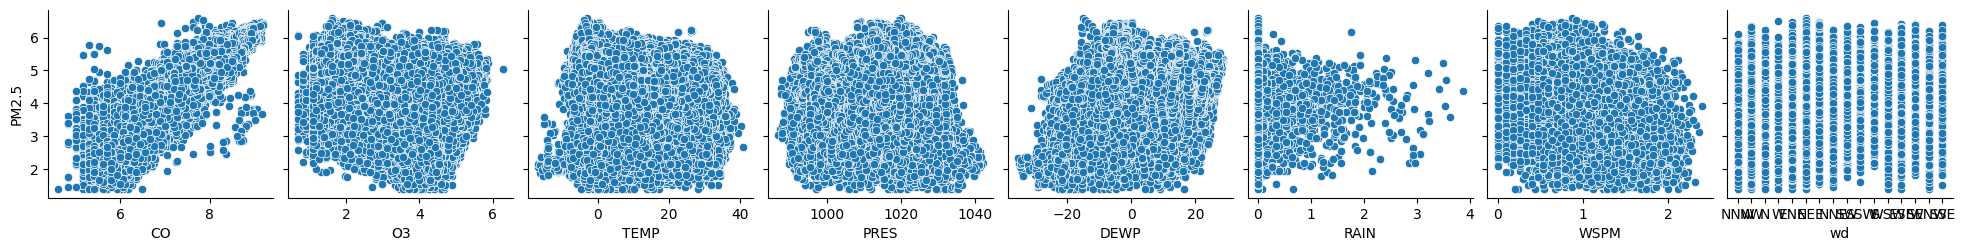

In [15]:
scatter_matrix_plot_seaborn(transformed_df, 'PM2.5')

### From the scatterplots, we can observe (empirically) that PM10, SO2, NO2, CO have strong correlations with PM2.5
### Since empirical observations are not enough, let's plot a heatmap to get the ACTUAL correlation values

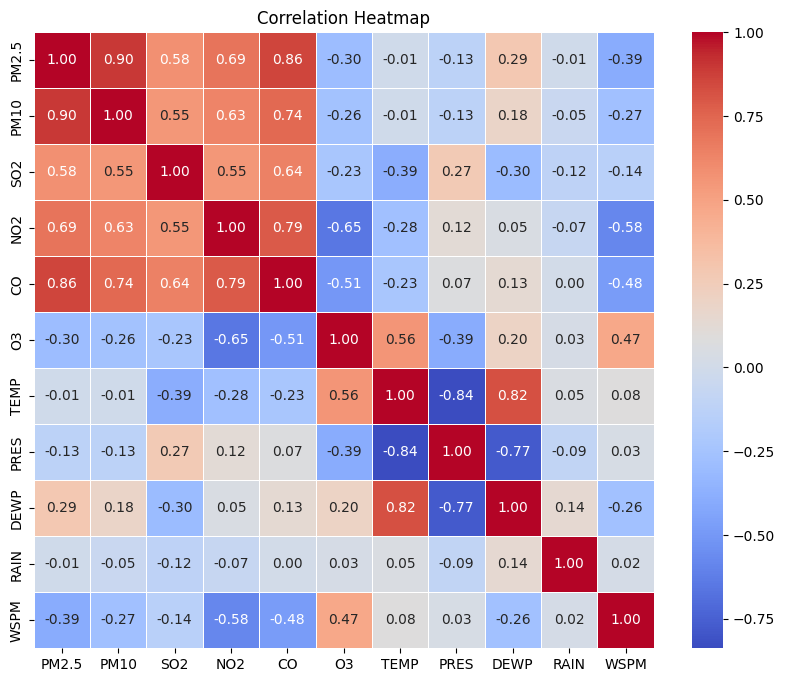

In [16]:
corr_matrix = transformed_df[numeric_columns].corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### We can confirm our empirical inference that PM10, SO2, NO2, and CO have strong positive correlations.
### However, we can see that O3, DEWP, WSPM have *moderate* correlations
### PRES, RAIN, TEMP have *weak to **VERY** weak* correlations
### This finding compliments our research done in existing Air Quality Research articles.

<a href="https://www.waikatoregion.govt.nz/environment/air/weather-and-air/#:~:text=or%20no%20wind.-,Wind%20speed,in%20dry%20windy%20rural%20areas.">Windspeed Article here</a>
```
Wind speed 
"Wind carries air contaminants away from their source, causing them to disperse. In general, the higher the wind speed, the more contaminants are dispersed and the lower their concentration. However, high wind can also generate dust – a problem in dry windy rural areas."
```
<a href="https://www.sciencedirect.com/science/article/abs/pii/S0048969723010501#:~:text=Through%20the%20combined%20effect%20of,autumn%20and%20winter%20in%20YRD.">O3 Article here</a>
```
"Through the combined effect of two chemical processes, PM2.5 can lead to a decrease in O3 concentration of −3.3 ppb (−7.6 %), −2.2 ppb (−4.0 %), −2.9 ppb (−6.3 %), and − 5.9 ppb (−18.7 %), in spring, summer, autumn and winter in YRD. Therefore, if the PM2.5 concentration decreases, the weakening effect of PM2.5 on the ozone concentration will be reduced, resulting in the aggravation of ozone pollution. "
```


### We are looking to find out if windspeed AND wind direction has an effect on PM2.5
### This is because the PM2.5 could be coming from a certain source in a certain direction, and the direction of wind could affect the PM2.5, not JUST the wind speed

### To start, let's visualize the WSPM by its group by applying a label on windspeed (high or low) and plot a boxplot

In [17]:
def group_wspm_median(wspm, median):
    if wspm <= median:
        return 'low'
    else:
        return 'high'

median_wspm = transformed_df['WSPM'].median()
transformed_df['grouped_wspm'] = transformed_df['WSPM'].apply(lambda x: group_wspm_median(x, median_wspm))

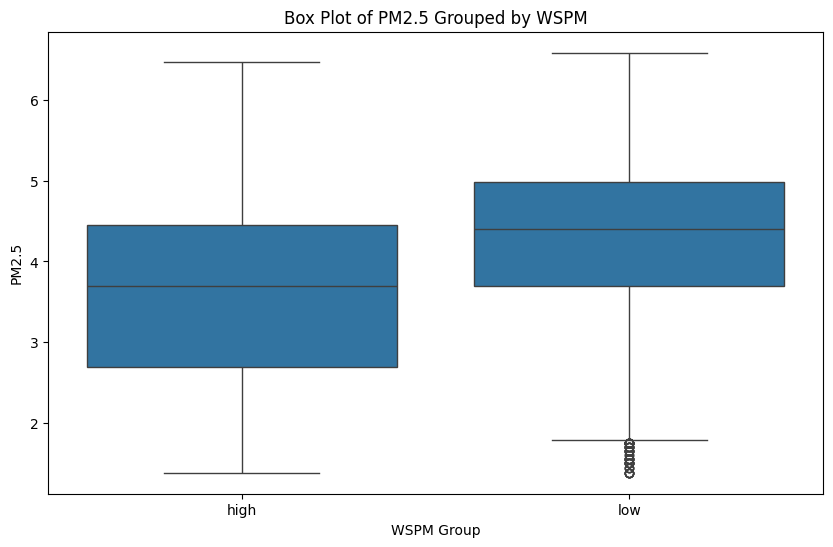

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grouped_wspm', y='PM2.5', data=transformed_df)
plt.title('Box Plot of PM2.5 Grouped by WSPM')
plt.xlabel('WSPM Group')
plt.ylabel('PM2.5')
plt.show()

### The boxplot shown indicates that the correlation is not a fluke. Higher windspeeds tend to reduce PM2.5 levels
### Let's take this insight a step further...

- To incorporate wind direction and windspeed into a single feature, we will take the orthogonal projection w.r.t. a reference vector 
<img src="img/orthogonal.png" height=200> <a href="https://textbooks.math.gatech.edu/ila/projections.html"><br>link to book here</a></img>

- In order to make this usable for our usecase, we need to manipulate the equation
- For any 2 vectors, A, B, A.B can be expressed as |A||B|cos(c), where c is the angle between A and B
- Knowing that we have the angles as defined by wind direction, c can be eaily computed
- ((u.x)/(u.u))u = (u.x)u', whereby u' is the unit vector of u
- (u.x)u' = |u||x|cos(c)u'
- given that u is our orthonormal basis, we can simplify the formula into
- projection = |x|cos(c) u'
- since we are only interested in the magnitude of the orthogonal projection w.r.t. u',
- projection_magnitude = |x|cos(c)
- This can be utilized by applying the following formula
```
wind_speed_projection = wind_speed * np.cos(np.radians(wind_direction_deg - reference_direction_deg)) #windspeed always non-negative
```
- To help visualize, I have plotted a diagram of wind directions for reference.
- I will iterate thru all possible directions to get the reference vector that has the best correlation with PM2.5

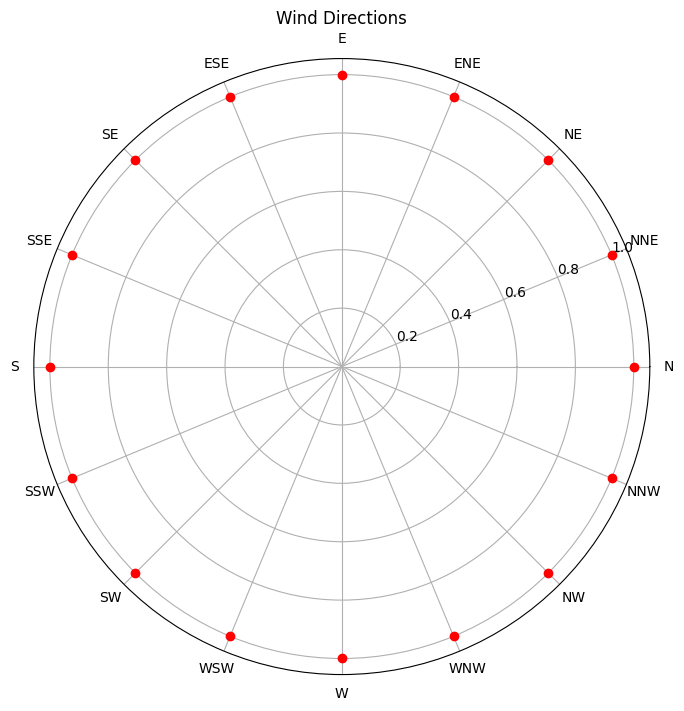

In [19]:
wind_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                   'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
angular_positions = np.arange(0, 360, 22.5)

# Plot wind directions
plt.figure(figsize=(8, 8))
plt.polar(np.radians(angular_positions), np.ones_like(angular_positions), 'ro')
plt.thetagrids(angles=np.degrees(np.radians(angular_positions)), labels=wind_directions)
plt.title('Wind Directions')
plt.show()

In [20]:
def calculate_projection_vector(row, reference_direction):
    # wind direction angles in degrees
    wind_direction_angles = {
        'N': 0.0, 'NNE': 22.5, 'NE': 45.0, 'ENE': 67.5,
        'E': 90.0, 'ESE': 112.5, 'SE': 135.0, 'SSE': 157.5,
        'S': 180.0, 'SSW': 202.5, 'SW': 225.0, 'WSW': 247.5,
        'W': 270.0, 'WNW': 292.5, 'NW': 315.0, 'NNW': 337.5
    }
    
    wind_speed = row['WSPM']
    wind_direction = row['wd']
    
    # map wind direction
    wind_direction_deg = wind_direction_angles[wind_direction]
    reference_direction_deg = wind_direction_angles[reference_direction]

    # dot product
    wind_speed_projection = wind_speed * np.cos(np.radians(wind_direction_deg - reference_direction_deg))
    
    return wind_speed_projection

wind_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                   'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
maximum = 0
max_label = ""
for i in wind_directions:
    transformed_df['projection'] = transformed_df.apply(lambda row: calculate_projection_vector(row, i), axis=1)
    print(i,transformed_df['projection'].corr(transformed_df['PM2.5']))
    if abs(transformed_df['projection'].corr(transformed_df['PM2.5'])) > maximum:
        maximum = transformed_df['projection'].corr(transformed_df['PM2.5'])
        max_label = i
print(f"Correlation result : {max_label} {maximum} has the strongest correlation")

N -0.36775103527435404
NNE -0.23670530789620844
NE -0.06855256772687257
ENE 0.1070681998276241
E 0.26319331308793875
ESE 0.3796624633748861
SE 0.4417824429195834
SSE 0.43902554505752556
S 0.3677510352743541
SSW 0.23670530789620844
SW 0.06855256772687254
WSW -0.10706819982762415
W -0.26319331308793875
WNW -0.37966246337488607
NW -0.4417824429195834
NNW -0.4390255450575255
Correlation result : SE 0.4417824429195834 has the strongest correlation


The correlation result indicates that wind direction 'SE' has the strongest correlation (0.4417824429195834) with PM2.5 levels. This correlation value suggests a moderately strong positive relationship between wind coming from the southeast direction and PM2.5 levels.

### Interpreting this result:

1. **Positive Correlation**: A positive correlation coefficient indicates that as the wind direction shifts towards 'SE', PM2.5 levels tend to increase. In other words, higher PM2.5 levels are associated with wind blowing from the southeast direction.

2. **Moderately Strong Correlation**: With a correlation coefficient of 0.44, the correlation between 'SE' wind direction and PM2.5 levels is moderately strong. This suggests that there is a noticeable tendency for PM2.5 levels to increase as the wind direction shifts towards the southeast, although other factors may also contribute to PM2.5 variability.

3. **Directional Influence**: The high correlation with wind direction 'SE' implies that factors such as sources of pollution or atmospheric conditions in the southeast direction may significantly impact PM2.5 levels. Understanding the specific sources or conditions associated with this wind direction could provide insights into the factors driving PM2.5 pollution in the area.

Because of these reasons, we believe that the projection column can be used as a feature in our model

In [21]:
transformed_df['projection'] = transformed_df.apply(lambda row: calculate_projection_vector(row, "SE"), axis=1)

In [22]:
transformed_df.corr(numeric_only=True)['PM2.5']

year         -0.058502
month         0.007948
day           0.020014
hour         -0.000475
PM2.5         1.000000
PM10          0.898888
SO2           0.581505
NO2           0.692261
CO            0.859583
O3           -0.298064
TEMP         -0.006584
PRES         -0.126010
DEWP          0.286921
RAIN         -0.010261
WSPM         -0.394748
projection    0.441782
Name: PM2.5, dtype: float64

### Before wrapping up this Notebook, we will take note our our top predictors
#### Categorical
- month
- hour
#### Numeric
- PM10
- SO2
- NO2
- CO
- O3
- DEWP
- projection

In [23]:
top_categorical_predictors = ['month', 'hour']
top_numeric_predictors = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'DEWP', 'projection']

top_predictors = top_categorical_predictors + top_numeric_predictors

In [24]:
total_df = transformed_df[top_predictors]

In [ ]:
top_predictors

['month', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'DEWP', 'projection']

In [26]:
def sqrt_transform_column(dataframe, columns):
        transformed_df = dataframe.copy()
        for column in columns:
            transformed_df[column] = np.sqrt(transformed_df[column])
        return transformed_df

In [27]:
columns_to_transform = skewed_cols
transformed_df = sqrt_transform_column(df, columns_to_transform)

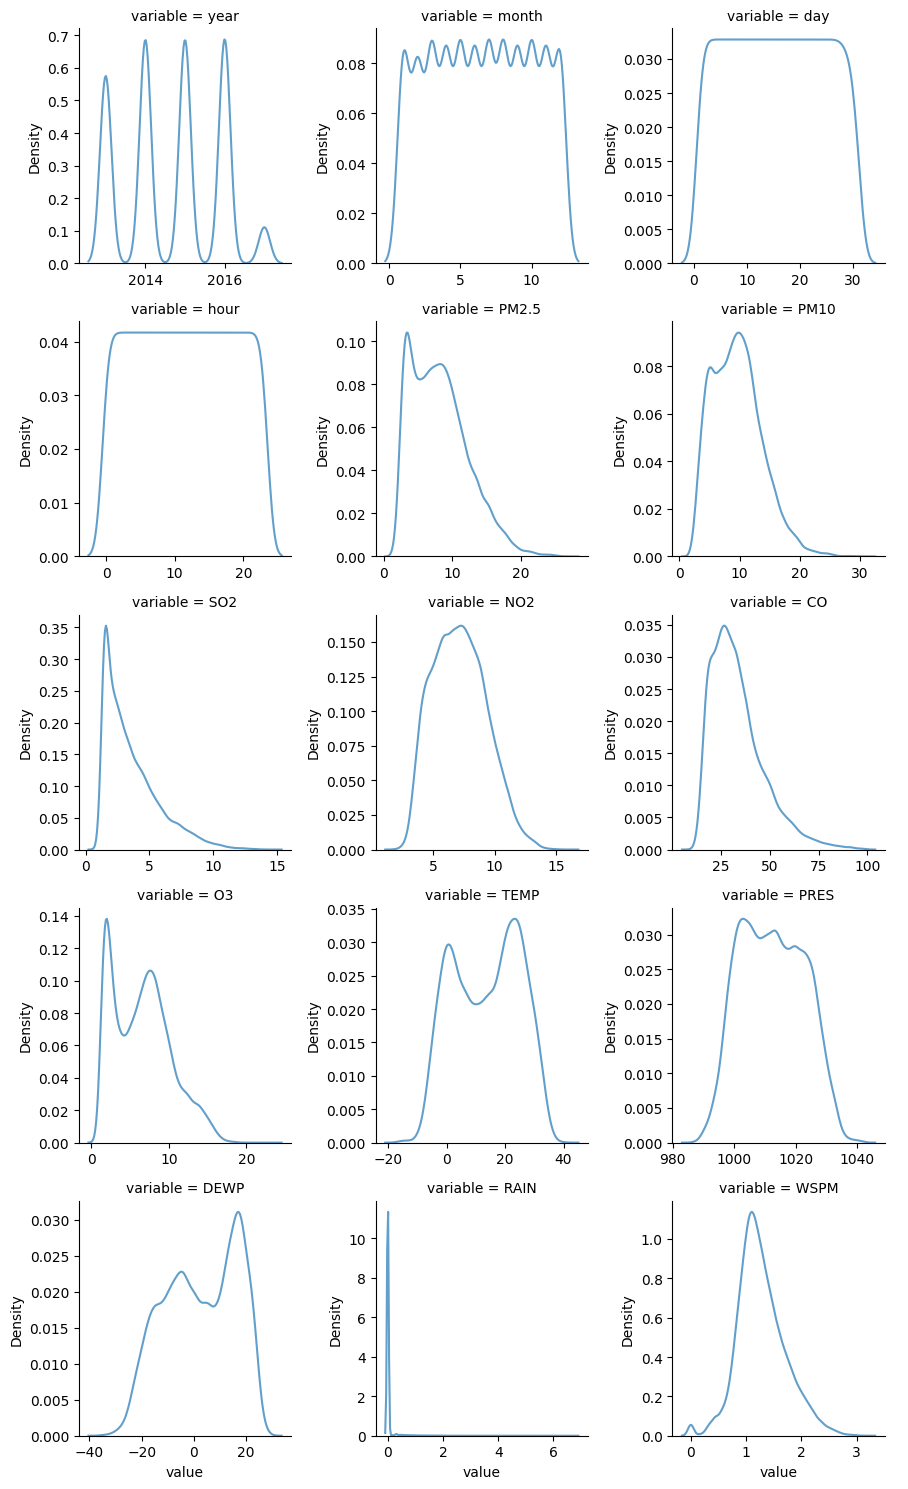

In [28]:
numerical_columns = transformed_df.select_dtypes(include=['float64', 'int64'])

# melt df
melted_df = pd.melt(transformed_df, value_vars=numerical_columns.columns)

# use sns facet for kde
g = sns.FacetGrid(melted_df, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', alpha=0.7)
g.add_legend()
plt.show()